## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [63]:
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [2]:
def image_loader(set_dir: str):
    images = []
    labels = []
    # Check if the directory contains class subfolders (train/val) or images directly (test)
    if any(os.path.isdir(os.path.join(set_dir, d)) for d in os.listdir(set_dir)):
        # Training/validation set: iterate each class folder
        class_dirs = sorted([d for d in os.listdir(set_dir) if os.path.isdir(os.path.join(set_dir, d))])
        for class_dir in class_dirs:
            class_path = os.path.join(set_dir, class_dir)
            for img_file in tqdm(sorted(os.listdir(class_path)), desc=f"Loading {class_dir}", unit="img"):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)  # BGR format
                if img is None: 
                    continue
                images.append(img)
                labels.append(class_dir)
    else:
        # Test set: images directly in folder, sorted by filename
        img_files = sorted(
            [f for f in os.listdir(set_dir) if os.path.isfile(os.path.join(set_dir, f))],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        for img_file in tqdm(img_files, desc="Loading testing set", unit="img"):
            img_path = os.path.join(set_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            images.append(img)
            labels.append("")  # no labels for test
    return images, labels

In [3]:
def img_resize(images: list, target_size: int = 224):
    if not images:
        return np.array([])
    processed_images = []
    for img in images:
        h, w = img.shape[:2]
        # Resize while preserving aspect ratio
        if h < w:
            new_h = target_size
            new_w = int(w * target_size / h)
        else:
            new_w = target_size
            new_h = int(h * target_size / w)
        img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        # Center crop to square target_size
        top = (img_resized.shape[0] - target_size) // 2
        left = (img_resized.shape[1] - target_size) // 2
        img_cropped = img_resized[top:top+target_size, left:left+target_size]
        processed_images.append(img_cropped)
    return np.stack(processed_images, axis=0)

In [4]:
images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

Loading african_elephant:   4%|▍         | 30/780 [00:00<00:02, 299.64img/s]

Loading testing set: 100%|██████████| 2600/2600 [00:07<00:00, 334.96img/s]


In [5]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [6]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [7]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.tensor(images_train.transpose(0, 3, 1, 2))
tensor_val   = torch.tensor(images_val.transpose(0, 3, 1, 2))
tensor_test  = torch.tensor(images_test.transpose(0, 3, 1, 2))


In [8]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

train_mean = tensor_train.mean(dim=[0, 2, 3])
train_std  = tensor_train.std(dim=[0, 2, 3])

# Standardize all sets using training statistics
tensor_train = (tensor_train - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_val   = (tensor_val   - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_test  = (tensor_test  - train_mean[None, :, None, None]) / train_std[None, :, None, None]

In [9]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the preprocessed tensors
torch.save(tensor_train, "tensor_train.pt")
torch.save(tensor_val, "tensor_val.pt")
torch.save(tensor_test, "tensor_test.pt")

# 6.2 Create unique label list and mappings
unique_labels = sorted(set(labels_train))  # assuming labels_train was loaded earlier
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map string labels to integer indices
labels_train_index = [label_to_index[label] for label in labels_train]
labels_val_index = [label_to_index[label] for label in labels_val]

# Convert to PyTorch tensors
labels_train_index = torch.tensor(labels_train_index, dtype=torch.long)
labels_val_index = torch.tensor(labels_val_index, dtype=torch.long)

# 6.4 Save label-related mappings and indices
torch.save(labels_train_index, "labels_train_index.pt")
torch.save(labels_val_index, "labels_val_index.pt")
torch.save(label_to_index, "label_to_index.pt")
torch.save(index_to_label, "index_to_label.pt")


In [160]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("tensor_train.pt")
tensor_val = torch.load("tensor_val.pt")
tensor_test = torch.load("tensor_test.pt")

labels_train_index = torch.load("labels_train_index.pt")
labels_val_index = torch.load("labels_val_index.pt")

/var/folders/xk/22ly48k565557xrbtq5p2dm80000gn/T/ipykernel_1562/295508795.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_train = torch.load("tensor_train.pt")
/v

KeyboardInterrupt: 

# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [ ]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [161]:
MAX_EPOCH = 5       
INIT_LR = 0.001
BATCH_SIZE = 16 #16???      
device = torch.device("cpu")


In [162]:
num_classes = len(torch.unique(labels_train_index)) 
resnet34 = torchvision.models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
resnet34 = resnet34.to(device)

In [163]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR)

criterion = nn.CrossEntropyLoss()

In [164]:
import torch
import torchvision
import torch.nn as nn

# 1. (Re)instantiate with the right head
num_classes = len(torch.unique(labels_val_index))
resnet34 = torchvision.models.resnet34(pretrained=False)
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
resnet34 = resnet34.to(device)

# 2. Load saved weights (skip fc mismatch)
ckpt = torch.load('resnet34_checkpoint.pkl', map_location=device)
filtered = {k: v for k, v in ckpt.items() if not k.startswith('fc.')}
resnet34.load_state_dict({**resnet34.state_dict(), **filtered})

# 3. Switch to eval mode
resnet34.eval()

# 4. Run your test loop (no optimizer needed)
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

test_ds = TensorDataset(tensor_val, labels_val_index)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

test_loss, correct = 0.0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = resnet34(x)
        test_loss += F.cross_entropy(out, y, reduction='sum').item()
        correct  += (out.argmax(1) == y).sum().item()

n = len(test_ds)
print(f"Test Loss: {test_loss/n:.4f}  |  Accuracy: {correct}/{n} = {correct/n:.4f}")


/var/folders/xk/22ly48k565557xrbtq5p2dm80000gn/T/ipykernel_1562/1611037873.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load('resnet34_

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([100, 512]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([10]).

In [153]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
import copy
import time

best_acc = 0.0
best_model_wts = copy.deepcopy(resnet34.state_dict())

train_accs_resnet34, train_losses_resnet34 = [], []
val_accs_resnet34, val_losses_resnet34 = [], []

for epoch in range(MAX_EPOCH):
    print(f'\nEpoch {epoch+1}/{MAX_EPOCH}')
    start_time = time.time()

    # Training
    resnet34.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    train_losses_resnet34.append(epoch_loss)
    train_accs_resnet34.append(epoch_acc.item())

    # Validation
    resnet34.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    val_losses_resnet34.append(val_epoch_loss)
    val_accs_resnet34.append(val_epoch_acc.item())

    print(f'Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')
    print(f"Epoch time: {(time.time() - start_time):.2f}s")

    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(resnet34.state_dict())
        torch.save(best_model_wts, 'resnet34_checkpoint.pkl')
        print("✅ Saved new best model.")

resnet34.load_state_dict(best_model_wts)




Epoch 1/5


python(9993) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9994) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KeyboardInterrupt: 

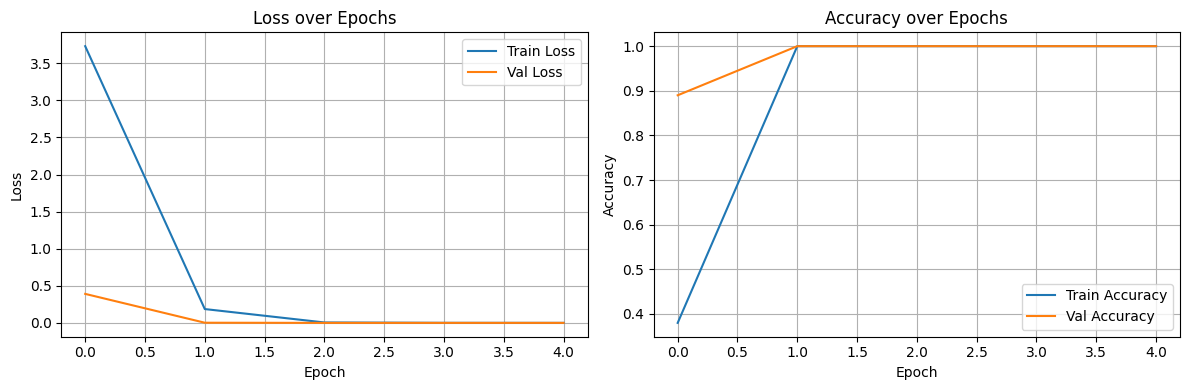

In [ ]:
# TODO: 5. Plot the loss and accuracy curves.
# Plot Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Accuracy')
plt.plot(val_accs_resnet34, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [138]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [139]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 50
INIT_LR = 0.001
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 3.0      # Typical distillation temp, smooths teacher probs
LOSS_RATIO = 0.9       # Weight for distillation loss; rest is for true label loss


In [140]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

/opt/anaconda3/envs/MSA/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [144]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Make sure to match the number of output classes

resnet34 = torchvision.models.resnet34(pretrained=False)

# Load the checkpoint
checkpoint = torch.load('resnet34_checkpoint.pkl', map_location=device)

# Remove the fc layer weights from the checkpoint
filtered_dict = {k: v for k, v in checkpoint.items() if not k.startswith('fc.')}

# Load only matching parameters
resnet34.load_state_dict({**resnet34.state_dict(), **filtered_dict})

# Replace the final layer to match your current task
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

# Move to device and set to evaluation mode
resnet34 = resnet34.to(device)
resnet34.eval()


/var/folders/xk/22ly48k565557xrbtq5p2dm80000gn/T/ipykernel_1562/285259991.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet34_checkpoint.pk

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [145]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

In [147]:
best_acc = 0.0
best_model_wts = copy.deepcopy(resnet18.state_dict())
train_accs_resnet18, train_losses_resnet18 = [], []
val_accs_resnet18, val_losses_resnet18 = [], []

print("labels_train_index:", np.unique(labels_train_index, return_counts=True))
print("labels_val_index:", np.unique(labels_val_index, return_counts=True))

for epoch in range(MAX_EPOCH):
    print(f"\nEpoch {epoch+1}/{MAX_EPOCH}")
    start_time = time.time()

    # === Train ===
    resnet18.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs_student = resnet18(inputs)

        with torch.no_grad():
            outputs_teacher = resnet34(inputs)

        # Losses
        loss_ce = F.cross_entropy(outputs_student, labels)
        loss_kd = F.kl_div(
            F.log_softmax(outputs_student / TEMPERATURE, dim=1),
            F.softmax(outputs_teacher / TEMPERATURE, dim=1),
            reduction='batchmean'
        ) * (TEMPERATURE ** 2)

        loss = LOSS_RATIO * loss_kd + (1. - LOSS_RATIO) * loss_ce

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs_student, 1)
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses_resnet18.append(epoch_loss)
    train_accs_resnet18.append(epoch_acc.item())

    # === Validation ===
    resnet18.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs_student = resnet18(inputs)
            outputs_teacher = resnet34(inputs)

            loss_ce = F.cross_entropy(outputs_student, labels)
            loss_kd = F.kl_div(
                F.log_softmax(outputs_student / TEMPERATURE, dim=1),
                F.softmax(outputs_teacher / TEMPERATURE, dim=1),
                reduction='batchmean'
            ) * (TEMPERATURE ** 2)

            loss = LOSS_RATIO * loss_kd + (1. - LOSS_RATIO) * loss_ce

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs_student, 1)
            val_running_corrects += torch.sum(preds == labels)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    val_losses_resnet18.append(val_loss)
    val_accs_resnet18.append(val_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Epoch time: {(time.time() - start_time):.2f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(resnet18.state_dict())
        torch.save(best_model_wts, 'resnet18_checkpoint.pkl')
        print("✅ Saved new best model.")

# Load best weights
resnet18.load_state_dict(best_model_wts)

labels_train_index: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([780, 780, 780, 780, 780, 780, 780, 780, 780, 780]))
labels_val_index: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([260, 260, 260, 260, 260, 260, 260, 260, 260, 260]))

Epoch 1/50


python(9497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


RuntimeError: The size of tensor a (7800) must match the size of tensor b (10) at non-singleton dimension 1

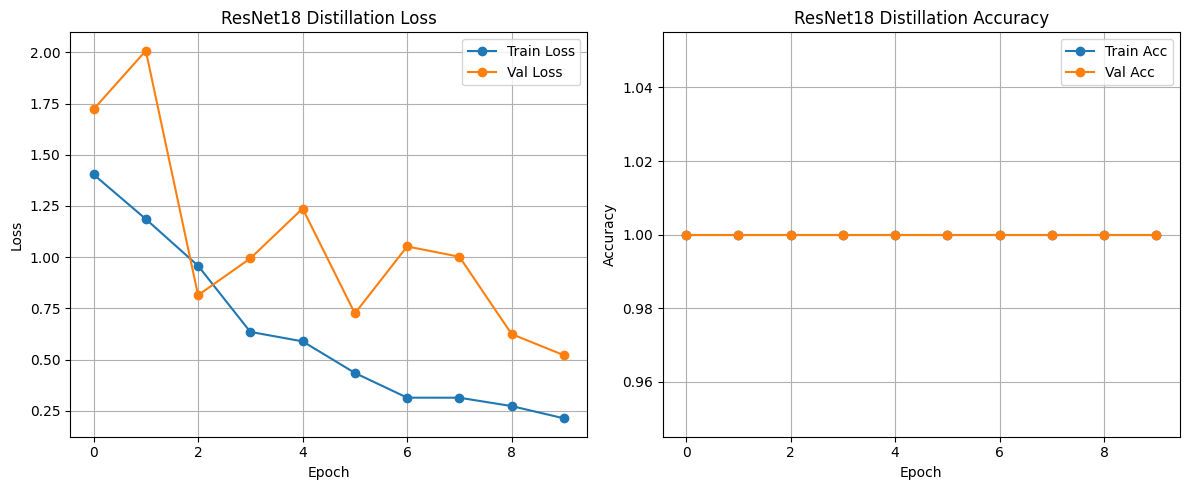

Train losses: [1.4038638162612915, 1.1861354207992554, 0.9581786346435547, 0.6354152584075927, 0.5892362356185913, 0.43507133960723876, 0.3143691873550415, 0.31413647532463074, 0.2733332228660583, 0.21347267985343932]
Val losses: [1.7218574380874634, 2.007904062271118, 0.8147203862667084, 0.9940990656614304, 1.2375788462162018, 0.7257115042209625, 1.0524319314956665, 1.0022861766815185, 0.6245729804039002, 0.5216956686973572]
Train accs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Val accs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [47]:
# TODO: 6. Plot the loss and accuracy curves.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss', marker='o')
plt.plot(val_losses_resnet18, label='Val Loss', marker='o')
plt.title('ResNet18 Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Acc', marker='o')
plt.plot(val_accs_resnet18, label='Val Acc', marker='o')
plt.title('ResNet18 Distillation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
print("Train losses:", train_losses_resnet18)
print("Val losses:", val_losses_resnet18)
print("Train accs:", train_accs_resnet18)
print("Val accs:", val_accs_resnet18)


# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [ ]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = 


In [ ]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []


In [ ]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = 
